# Random forest for user churn prediction

In this notebook we try to use Random forest to perform prediction over user's churn. We perform various feature engineering, feature selection, and visualize our findings about most important features.

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
rng = np.random.RandomState(117)

In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Reading data

We will create following features: 

1) For each type of event in the given data we add feature #count of event

2) Additionaly we find time between first and last user transaction (in days), average between-transaction time, number of transactions, phone model and state of user

In [4]:
df = pd.read_csv('int20h-ds-test-dataset.csv', parse_dates=['event_created_date'])

grouped_df = df.groupby('userid')

In [5]:
unique_event_names = sorted(list(set(df['event_name'])))

from_data_features = len(unique_event_names)

unique_event_names.append('Time of use')
unique_event_names.append('Phone model')
unique_event_names.append('State')
unique_event_names.append('Average time')
unique_event_names.append('Number of actions')

regressed_data = []

id_target = 'Subscription Premium Cancel'
bid = 'Subscription Premium'

mrdict = {x:[] for x in unique_event_names}

y = []

for i, (name, col) in enumerate(grouped_df):
    translated = list(col['event_name'])
    if not bid in translated:
        continue
    time = (  col['event_created_date'].max() - col['event_created_date'].min()).days
    phone = list(col['event_platform'])[0]
    state = list(col['user_state'])[0]
    num = len(col)
    av_time = time/num
    
    translated.remove(bid)
    regressed_data.append(np.zeros(len(unique_event_names)))
    y.append(0)
    if id_target in translated:
        j = translated.index(id_target)
        translated = translated[:j]
        y[-1] = 1

    unique, counts = np.unique(translated, return_counts=True)

    for x in unique_event_names[:from_data_features]:
        mrdict[x].append(0)

    for val, cnt in zip(unique, counts):
        mrdict[val][-1] = cnt
    for name, val in zip(unique_event_names[from_data_features:], [time, phone, state, av_time, num]):
        mrdict[name].append(val)
    
data = pd.concat([pd.DataFrame(mrdict), pd.Series(y, name = 'Value')], axis = 1)

In [6]:
data.columns

Index(['Account History Transaction Details', 'Account Setup Profile Skip',
       'Account Setup Skip', 'Add Payment Method Failed',
       'Add Payment Method Success', 'Add Vehicle Break', 'Add Vehicle Failed',
       'Add Vehicle Success', 'Calculator Used', 'Calculator View',
       'Chat Conversation Opened', 'Chat Conversation Started',
       'Email Confirmation Success', 'Order', 'Reset Password Set', 'Sign Out',
       'Sign Up Error', 'Sign Up Success', 'Subscription Premium',
       'Subscription Premium Cancel', 'Subscription Premium Renew',
       'Transaction Refund', 'Wallet Opened', 'Time of use', 'Phone model',
       'State', 'Average time', 'Number of actions', 'Value'],
      dtype='object')

## Ploting density and data analysis

We can view density of different users with regard to various numerical features to perform feature selection

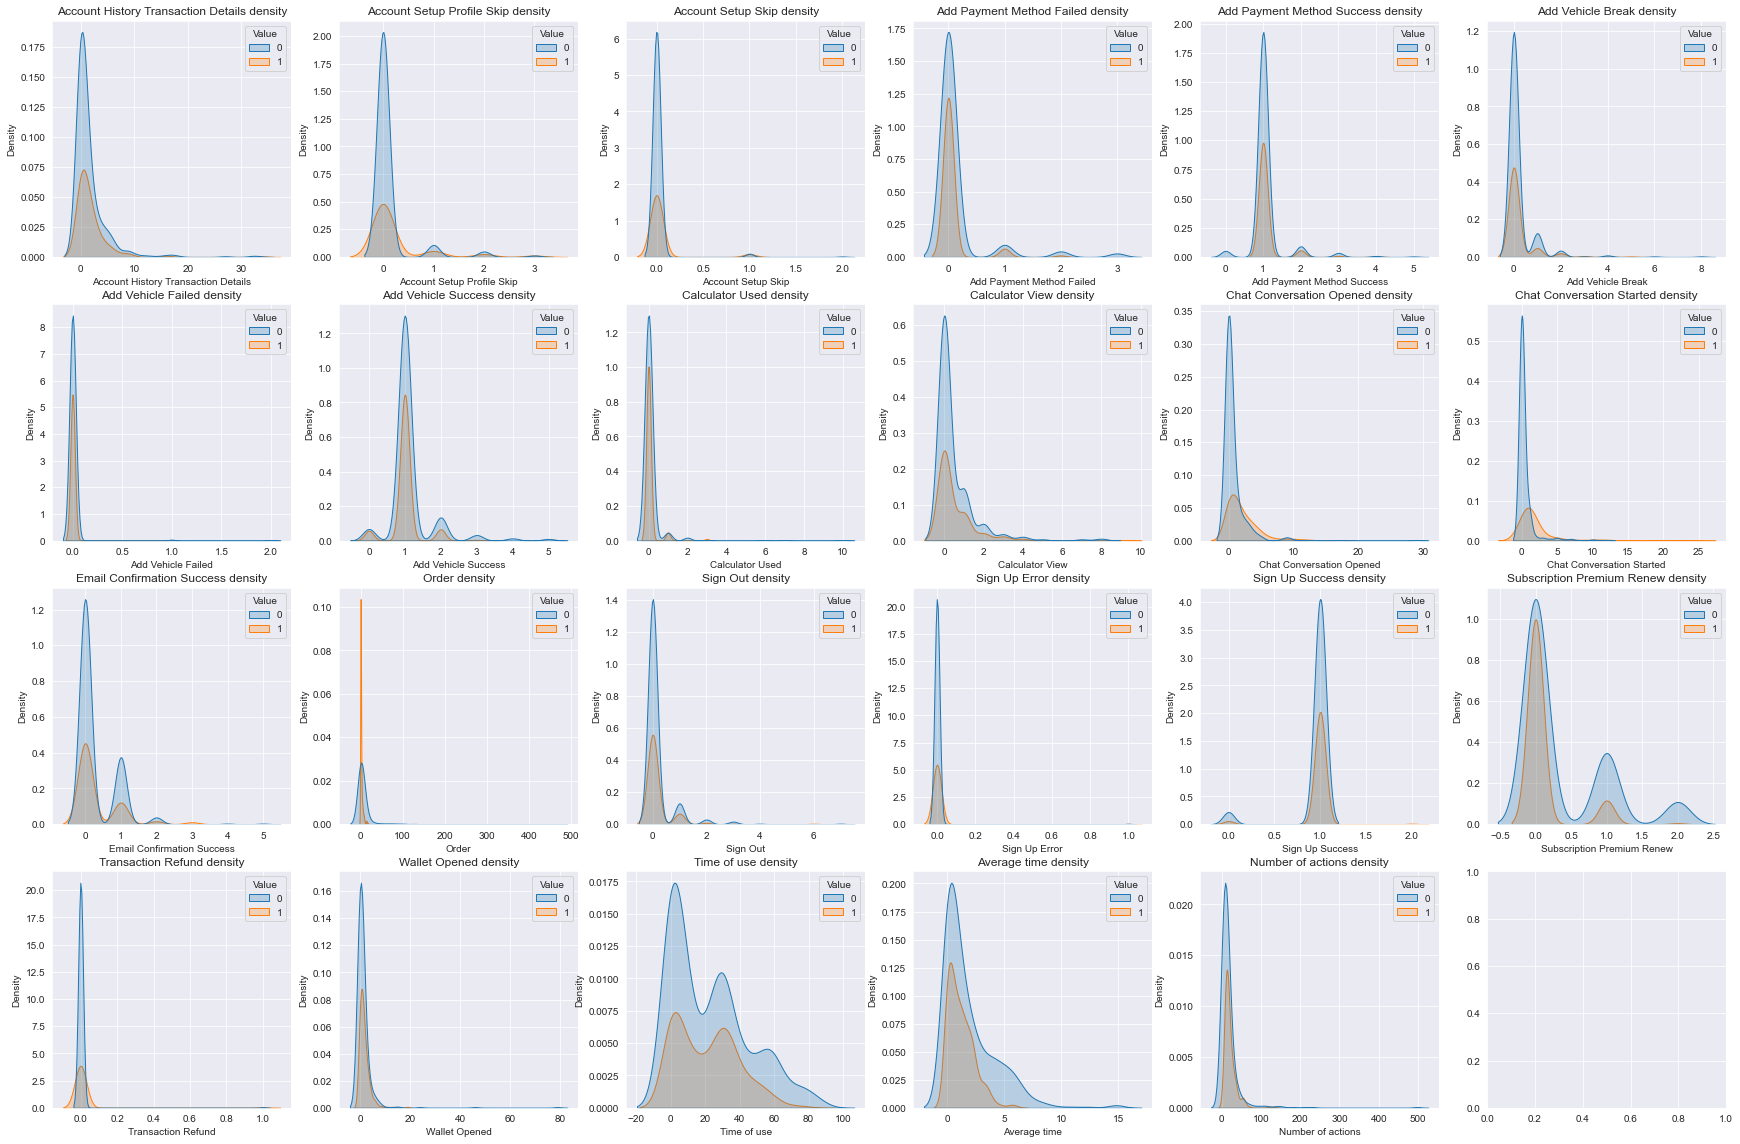

In [7]:
features = ['Account History Transaction Details', 'Account Setup Profile Skip',
       'Account Setup Skip', 'Add Payment Method Failed',
       'Add Payment Method Success', 'Add Vehicle Break', 'Add Vehicle Failed',
       'Add Vehicle Success', 'Calculator Used', 'Calculator View',
       'Chat Conversation Opened', 'Chat Conversation Started',
       'Email Confirmation Success', 'Order', 'Sign Out',
       'Sign Up Error', 'Sign Up Success',
       'Subscription Premium Renew',
       'Transaction Refund', 'Wallet Opened', 'Time of use', 'Average time', 'Number of actions']

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (30, 20)

fig, ax = plt.subplots(4,6)

for i, val in enumerate(features):
    sns.kdeplot(data, x = val, hue = 'Value', ax = ax[i // 6][i % 6], fill = True).set(title = f'{val} density')


Lets inspect some features closely removing samples with zero activations on them

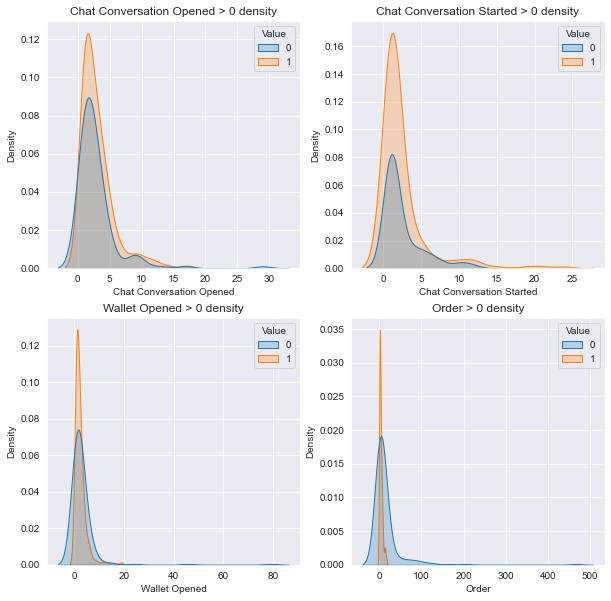

In [8]:
plt.rcParams['figure.figsize'] = (10, 10)

additional = ['Chat Conversation Opened', 'Chat Conversation Started', 'Wallet Opened', 'Order']

fig, ax = plt.subplots(2,2)

for i, val in enumerate(additional):
    sns.kdeplot(data[data[val] > 0], x = val, hue = 'Value', ax = ax[i // 2][i % 2], fill = True).set(title = f'{val} > 0 density')


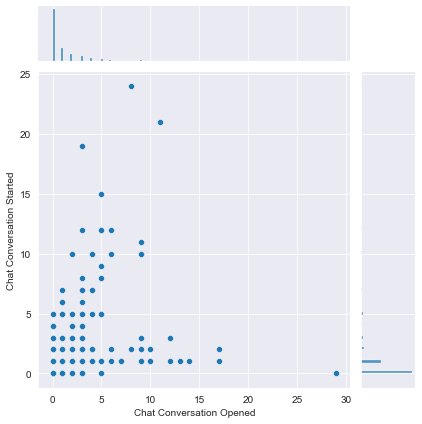

In [9]:
sns.jointplot(data = data, x = 'Chat Conversation Opened', y = 'Chat Conversation Started')

## Feature selection

We will remove all useless "peaks"

In [10]:
to_drop = ['Sign Up Error', 'Transaction Refund', 'Add Vehicle Failed', 'Calculator Used', 'Sign Up Error', 'Transaction Refund', 'Subscription Premium', 'Subscription Premium Cancel', 'Reset Password Set']

Parsing dataset into sklearn-friendly format

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

data_reg = data.drop(columns = to_drop)
y = data_reg['Value']
data_reg.drop(columns=['Value'], inplace=True)


transformer = ColumnTransformer([
    ('Categories', OneHotEncoder(min_frequency=0.1), ['State', 'Phone model'])
], remainder='passthrough', verbose_feature_names_out=False)
X = transformer.fit_transform(data_reg)


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

## Model selection

First, lets select the forest tree using cross validation

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


params = {
    'criterion' : ["gini", "entropy", "log_loss"],
    'n_estimators' : [20, 50, 100, 200],
    'min_samples_leaf': [0.1, 5, 10],
    'max_features' : ["sqrt", "log2", None, 0.2, 0.5],
    'bootstrap' : [False, True],
    'max_depth' : [3, 6, 9]
}

model = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state = rng), params, n_jobs=-1)
model.fit(X_train, y_train)
clf = model.best_estimator_

results = pd.Series(index = ['Train', 'Test'])

results['Train'] = clf.score(X_train, y_train)
results['Test'] = clf.score(X_test, y_test)

print(results)


Train    0.936210
Test     0.803371
dtype: float64


C:\Users\bidzi\AppData\Local\Temp\ipykernel_11624\1409677045.py:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  results = pd.Series(index = ['Train', 'Test'])


In [14]:
model.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 0.5,
 'min_samples_leaf': 5,
 'n_estimators': 100}

              precision    recall  f1-score   support

           0       0.90      0.80      0.84       119
           1       0.67      0.81      0.73        59

    accuracy                           0.80       178
   macro avg       0.78      0.81      0.79       178
weighted avg       0.82      0.80      0.81       178



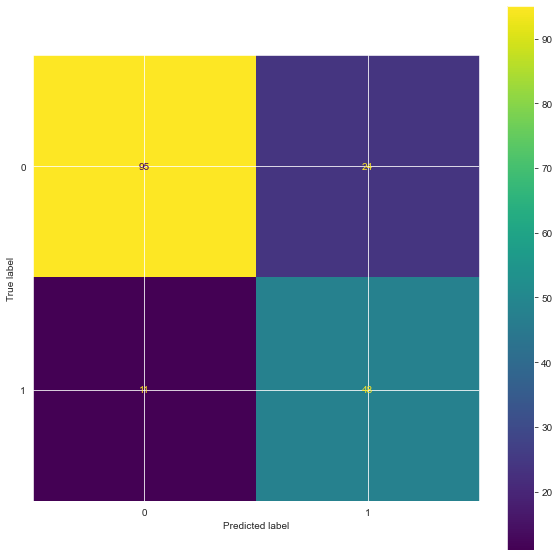

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

## Forest feature importances

[Text(0.5, 1.0, 'Feature importances for decision tree')]

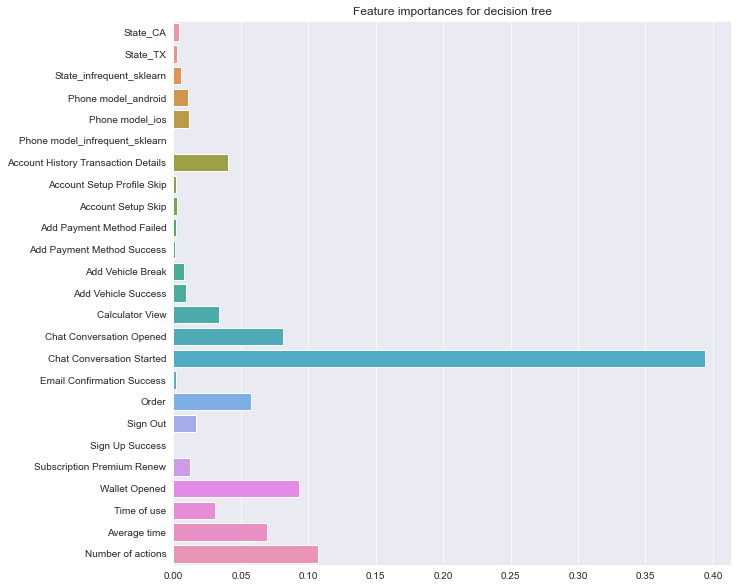

In [16]:

sns.barplot(x = clf.feature_importances_, y = transformer.get_feature_names_out()).set(title = 'Feature importances for decision tree')

## SHAP feature importances

Lets view SHAP values for our model

In [17]:
import shap
shap.initjs()

In [18]:
explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X_test)


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


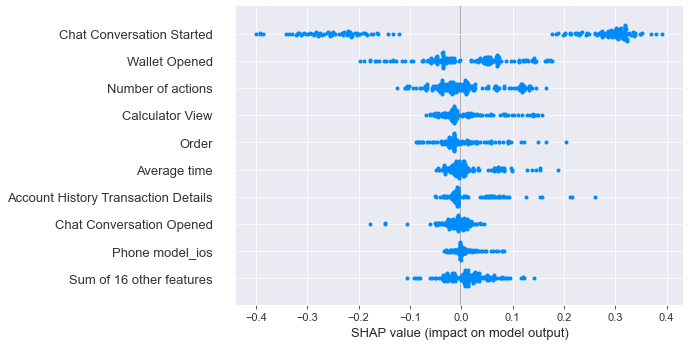

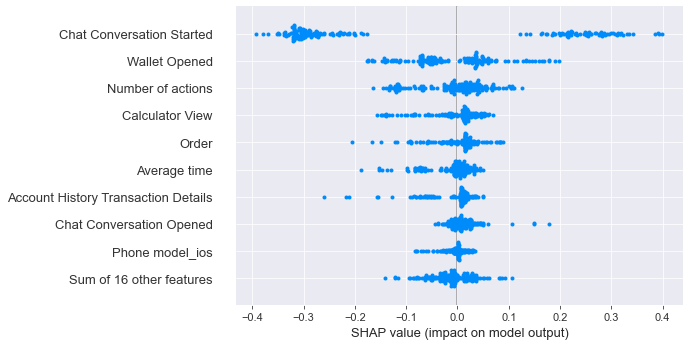

In [19]:
shap.plots.beeswarm(shap.Explanation(values = shap_values[0],feature_names=transformer.get_feature_names_out()))
shap.plots.beeswarm(shap.Explanation(values = shap_values[1],feature_names=transformer.get_feature_names_out()))

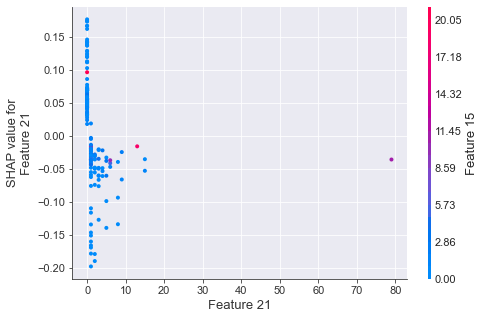

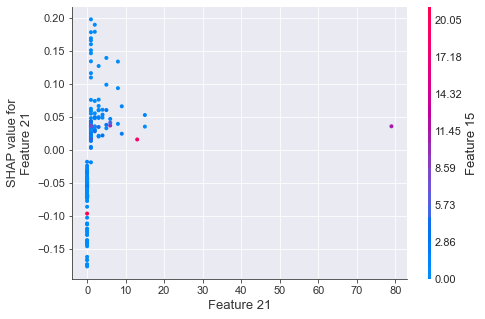

In [39]:
id = list(transformer.get_feature_names_out()).index('Wallet Opened')


shap.dependence_plot(id, shap_values[0], X_test)
shap.dependence_plot(id, shap_values[1], X_test)

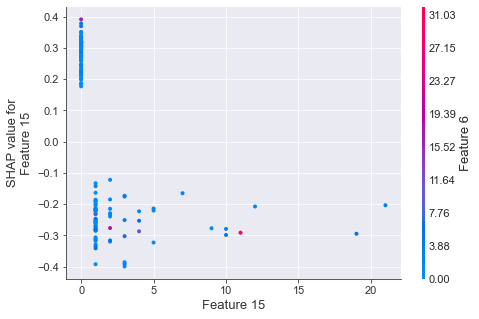

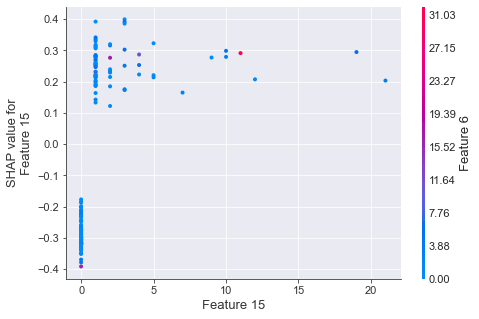

In [40]:
id = list(transformer.get_feature_names_out()).index('Chat Conversation Started')


shap.dependence_plot(id, shap_values[0], X_test)
shap.dependence_plot(id, shap_values[1], X_test)

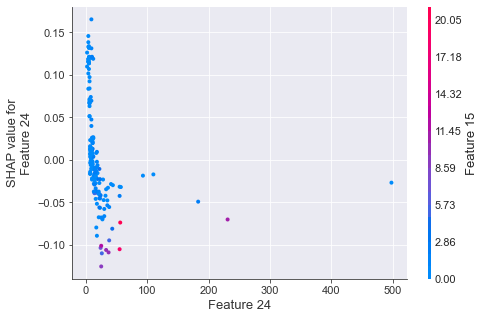

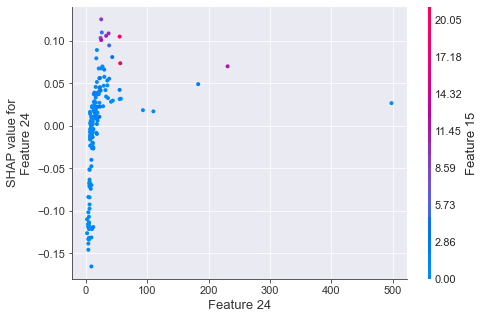

In [41]:
id = list(transformer.get_feature_names_out()).index('Number of actions')


shap.dependence_plot(id, shap_values[0], X_test)
shap.dependence_plot(id, shap_values[1], X_test)

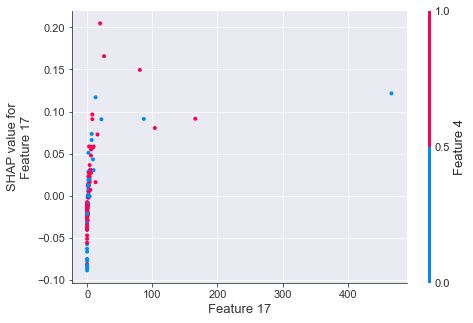

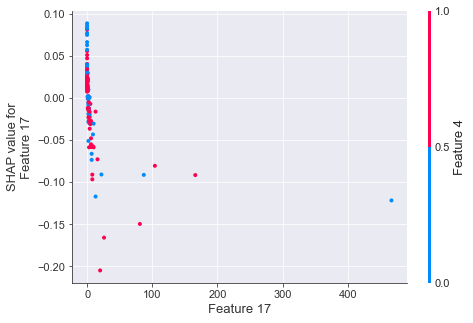

In [42]:
id = list(transformer.get_feature_names_out()).index('Order')


shap.dependence_plot(id, shap_values[0], X_test)
shap.dependence_plot(id, shap_values[1], X_test)

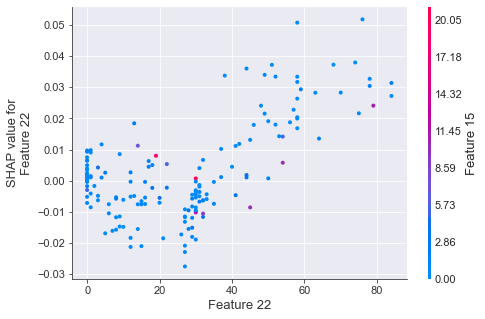

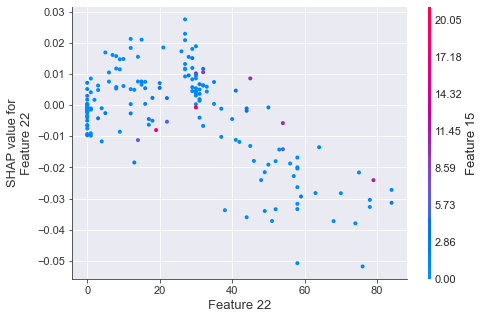

In [48]:
id = list(transformer.get_feature_names_out()).index('Time of use')


shap.dependence_plot(id, shap_values[0], X_test)
shap.dependence_plot(id, shap_values[1], X_test)

We can view individual prediction explanation uing SHAP as follows:

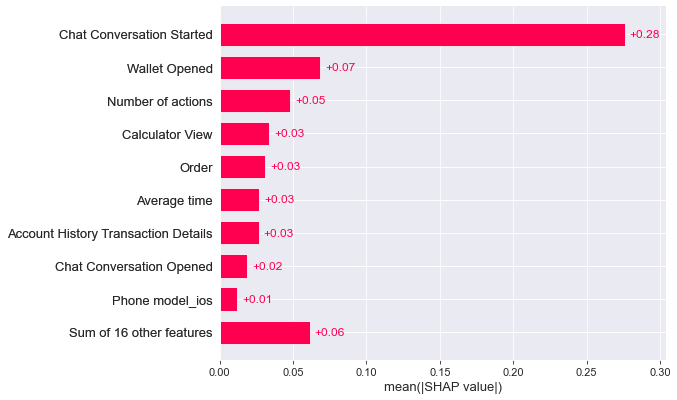

In [ ]:
shap.plots.bar(shap.Explanation(values = shap_values[1],feature_names=transformer.get_feature_names_out()))

## Conclusion

Decision tree found by cross validation indicated the importance of chat support opened, wallet opened and number of actions. 